- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Learning
    - Need at least 2 vehicles so that there is a neighbor in the front
    - Otherwise src/1d/driver/lane_follower_driver errors
    - That is why the `AutomotiveDrivingModels/doc/1DMobius` stuff does 
    not work with 1 car only (needs at least 2 cars)
    - The tutorial does not work with `gen_straight_roadway` because that
    generates a roadway of type AutomotiveDrivingModels.roadway as opposed to
    AutomotiveDrivingModels.StraightRoadway
- Open question
    - IDM won't work unless there is a car in front (errors saynig nothing in sight)
    - We are focusing on learning the params of the second car here. Is that sound sensible?
- Flow of code
    - Call the required `usings`
    - Define functions required
    - Actual running things
        - Generate true trajectory
        - Generate a set of particles uniformly between sensible range of values
        - Compute fitness, sort and select numtop
        - Fit a distribution over this
        - Resample particles
- Scenario
    - Slower car in front (car 1)
    - Faster car behind (car 2)
    - We want to estimate params of car 2
- Feb 10: Adding timegap_des as our 2nd param in the 2 car, 1D, IDM scenario
    - Make code capable of handling 2d param. So far, had only scalar param
    i.e v_des
    - Fitting 2D distributions is required now

In [12]:
using AutomotiveDrivingModels
using AutoViz
using Reel
using Interact
using StatsBase # For random particle generation

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [1]:
# Test: Generate samples for a 2d distb
d2 = MvNormal(2,2.0) # first arg shows dimension, second shows std dev
qw = rand(d2,6) # Will generate 6 samples i.e. 6 columns

LoadError: [91mUndefVarError: MvNormal not defined[39m

In [90]:
# Test: Fit 2d distribution
dx = Normal()
dy = Normal(2,1.0)
x = rand(dx,100)
y = rand(dy,100)

# Matrix with each column being a sample
# Total columns is total number of samples
# Total rows is number of parameters
# All entries in a row contain value from same param eg:v_des
data_matrix = vcat(x',y')
fit(MvNormal,data_matrix)

FullNormal(
dim: 2
μ: [-0.120248, 2.00635]
Σ: [1.0179 0.0694388; 0.0694388 0.95558]
)


In [17]:
# 1 lane, 1000 m roadway
# roadway = gen_straight_roadway(1,1000.0) # Does not work with the below because AutomotiveDrivingModels.Roadway
roadway = StraightRoadway(1000.0); # AutomotiveDrivingModels.StraightRoadway type

In [13]:
# Function: Initialize the scene
    # Note: Vehicle def 2 is the one we learn params for
    # This is hard-coded in the gen_traj method
function init_scene()
    scene = Scene1D()
    
    # First arg to State1D is pos, 2nd arg is velocity
    push!(scene, Entity(State1D(10.0, 20.0), VehicleDef(), 2))
    push!(scene, Entity(State1D(50.0, 12), VehicleDef(), 1))
    return scene
end

init_scene (generic function with 1 method)

In [30]:
x = [1 2 3;4 5 6]
x[:,2]

2-element Array{Int64,1}:
 2
 5

In [20]:
# Function: Generate trajectory
    # Other functions called: init_scene
    # How to call: hallucinated_traj = gen_traj(proposed_param)
    # Caution: Params is a 2 elem array for now with v_des and T as elems
function gen_traj(params;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
    models[2] = IntelligentDriverModel(v_des=params[1],T=params[2])

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    # Extract the position and velocity of nticks timesteps
    # X stores this as 2d array. Timestep is the row, col 1 is pos,vel is pos2
    n_cars = scene.n
    n_ticks = nticks
    X = Array{Float64}(n_ticks, 1)

    for t in 1:n_ticks
        f = rec.frames[n_ticks - t + 1]
        
        # BAD: 2 cars in scene therefore loop has only 1 elem
        for c in 2:scene.n #TODO: THIS IS A PITFALL AND IS HARDCODED
            s = f.entities[c].state
            X[t, 1] = s.s #position
        end
    end
    return X
end

gen_traj (generic function with 1 method)

$\sum_{t=1}^{t=end}\mid truePos_t - hallucinatedPos_t \mid$

In [8]:
# Function: Calculate abs pos error at every timestep
#    Some up those errors to create an error over entire traj
function calc_traj_error(traj1,traj2)
    return sum(abs.(traj1-traj2))
end

calc_traj_error (generic function with 1 method)

In [27]:
# Generate the true trajectory
true_param = 20.0
true_traj = gen_traj(true_param);

In [69]:
# Function: Run an iteration i.e. take a set of params and return
#    a new set
function new_p_from_old(p_vdes)

    # Loop over the set of particles and calculate traj_error
    p_traj_error = Array{Float64}(length(p_vdes))
    for (i,proposed_vdes) in enumerate(p_vdes)
        proposed_traj = gen_traj(proposed_vdes)
        p_traj_error[i] = calc_traj_error(true_traj,proposed_traj)
    end

    # We don't care about the actual error values
    # We just care about the numtop lowest of them

    # Collect the indices of the lowest to highest elems
    #    in the traj error vector
    sortedidx = sortperm(p_traj_error)
    

    # Select the numtop from the original particles
    numtop = 15
    new_p_vdes = p_vdes[sortedidx[1:numtop]]
    @show "sortedNselectedtop"
    # Use the numtop particles to fit a Gaussian
    @show new_p_vdes
    p_dist = fit(Normal,new_p_vdes)
    @show p_dist

    # Sample num_p new particles from this fitted distb
    p_vdes_new = round.(rand(p_dist,num_p))
    @show p_vdes_new
    return p_vdes_new
end

new_p_from_old (generic function with 1 method)

In [70]:
p_start_val = 18.0;p_end_val = 40.0;num_p = 50
p_vdes = sample(p_start_val:p_end_val, num_p, replace = true)
@show p_vdes

init_dist = fit(Normal,p_vdes)
@show init_dist

p_old = p_vdes
for i in 1:10
    @show i
    p_new = new_p_from_old(p_old)
    p_old = p_new
end
# @show p_test

p_vdes = [26.0, 37.0, 20.0, 24.0, 33.0, 33.0, 20.0, 36.0, 39.0, 31.0, 19.0, 40.0, 24.0, 33.0, 37.0, 20.0, 33.0, 36.0, 22.0, 37.0, 32.0, 29.0, 27.0, 30.0, 36.0, 38.0, 34.0, 27.0, 23.0, 21.0, 26.0, 19.0, 20.0, 27.0, 38.0, 36.0, 32.0, 27.0, 31.0, 40.0, 33.0, 37.0, 32.0, 37.0, 36.0, 23.0, 40.0, 20.0, 29.0, 37.0]
init_dist = Distributions.Normal{Float64}(μ=30.34, σ=6.601848226065182)
i = 1
"sortedNselectedtop" = "sortedNselectedtop"
new_p_vdes = [20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 19.0, 19.0, 22.0, 23.0, 23.0, 24.0, 24.0, 26.0, 26.0]
p_dist = Distributions.Normal{Float64}(μ=21.8, σ=2.3151673805580453)
p_vdes_new = [18.0, 22.0, 22.0, 17.0, 24.0, 22.0, 24.0, 25.0, 25.0, 22.0, 24.0, 22.0, 25.0, 19.0, 27.0, 24.0, 20.0, 20.0, 23.0, 24.0, 22.0, 19.0, 20.0, 22.0, 18.0, 26.0, 23.0, 23.0, 21.0, 23.0, 23.0, 20.0, 25.0, 21.0, 25.0, 21.0, 18.0, 24.0, 18.0, 23.0, 22.0, 24.0, 23.0, 20.0, 22.0, 24.0, 19.0, 24.0, 16.0, 24.0]
i = 2
"sortedNselectedtop" = "sortedNselectedtop"
new_p_vdes = [20.0, 20.0, 20.0,

LoadError: [91mArgumentError: Normal: the condition σ > zero(σ) is not satisfied.[39m

In [29]:
# Loop over the set of particles and calculate traj_error
p_traj_error = Array{Float64}(length(p_vdes))
for (i,proposed_vdes) in enumerate(p_vdes)
    proposed_traj = gen_traj(proposed_vdes)
    p_traj_error[i] = calc_traj_error(true_traj,proposed_traj)
end

In [30]:
# We don't care about the actual error values
# We just care about the numtop lowest of them

# Collect the indices of the lowest to highest elems
#    in the traj error vector
sortedidx = sortperm(p_traj_error)

# Select the numtop from the original particles
numtop = 10
new_p_vdes = p_vdes[sortedidx[1:numtop]]

10-element Array{Float64,1}:
 20.0
 21.0
 21.0
 19.0
 19.0
 19.0
 22.0
 22.0
 22.0
 23.0

In [15]:
# Use the numtop particles to fit a Gaussian
p_dist = fit(Normal,new_p_vdes)

Distributions.Normal{Float64}(μ=20.2, σ=0.7483314773547883)

In [20]:
# Sample num_p new particles from this fitted distb
p_v_des = round.(rand(p_dist,num_p))

50-element Array{Float64,1}:
 19.0
 21.0
 21.0
 22.0
 21.0
 19.0
 21.0
 20.0
 21.0
 19.0
 20.0
 21.0
 18.0
  ⋮  
 20.0
 19.0
 19.0
 20.0
 21.0
 21.0
 20.0
 20.0
 20.0
 21.0
 20.0
 20.0

## Particle Filter Idea tabled for now

In [ ]:
# Hallucinate a step using all the particles
raise()
for (i,my_v_des) in enumerate(p_vdes)
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
    models[2] = IntelligentDriverModel(v_des=my_v_des) # default IDM with a desired speed of 12 m/s

    nticks = 0.1
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
end

In [ ]:
# Compare every particles hallucination to
# the master trajectory (what actually happened)
# and assign a weight

In [ ]:
models = Dict{Int, LaneFollowingDriver}()
models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
models[2] = IntelligentDriverModel(v_des=20.0) # default IDM with a desired speed of 12 m/s

nticks = 5
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
@show length(rec.frames)

In [ ]:
fieldnames(rec.frames[1].entities[1].state)

In [ ]:
fieldnames(IntelligentDriverModel)

In [ ]:
# From djp chmm bitbucket. src/toy_driving_data.jl
n_cars = scene.n
n_ticks = nticks
X = Array{Float64}(n_cars, n_ticks, 3)

for t in 1:n_ticks
    f = rec.frames[n_ticks - t + 1]
    for c in 1:scene.n
        s = f.entities[c].state
        X[c, t, 1] = s.s #position
        X[c, t, 2] = s.v #speed
    end
end

Ideas:
- Hallucination and weighting can happen in same iteration
- Should we correct the position of the car to what actually happened after every timestep

In [ ]:
# Function: Return rec corresponding to generated traj
    # Will help visualizatoin
    # Calls init_scene
function gen_rec4vid(param_vdes;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
    models[2] = IntelligentDriverModel(v_des=param_vdes)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    return rec
end

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_11", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-8e7f32ac-aed4-412a-9a12-52a6459320f2", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 101),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_10", 51, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/all.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/style.css", "/home/raunak/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {retu
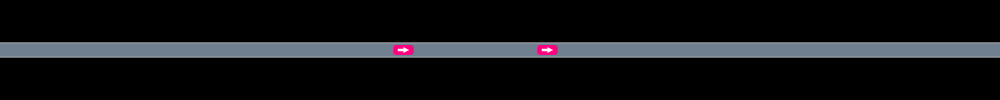
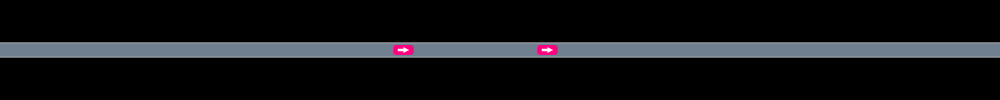

In [31]:
# overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true,
#         pos=VecE2(veh.state.s-0.7, 3)) for veh in scene];
# render(scene, roadway, overlays, cam=cam, canvas_height=100)

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
true_rec = gen_rec4vid(true_param)
rec = true_rec
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# 2D experimentation

In [ ]:
roadway = gen_straight_roadway(2,1000.0);

In [ ]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

In [ ]:
models = Dict{Int64, DriverModel}()
models[1] = Tim2DDriver(0.1) # always produce zero acceleration
models[2] = Tim2DDriver(0.1) # default IDM with a desired speed of 12 m/s

nticks = 100
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)